<a href="https://colab.research.google.com/github/Ruturajjadhav35/Context-Aware-Fake-News-Detection-and-Fact-Verification-/blob/main/Final_Fake_news_detection_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import classification_report

# Installing Colab environment
!pip install spacy wikipedia transformers --quiet
import spacy
import wikipedia
from transformers import AutoModelForSequenceClassification, AutoTokenizer


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
fake_data = pd.read_csv('/content/drive/MyDrive/ColabDatasets/Fake.csv')
true_data = pd.read_csv('/content/drive/MyDrive/ColabDatasets/True.csv')

# Context-Aware Fake News Detection and Fact Verification

In this project, I built a pipeline that not only detects fake news but also goes further by extracting factual claims and verifying them against trusted sources like Wikipedia.  
The pipeline is composed of three stages:
1. **Fake News Detection (BERT classifier)** – Identify whether a news article is fake or real.
2. **Claim Extraction (spaCy)** – Pull out factual statements from the article text.
3. **Claim Verification (RoBERTa-MNLI)** – Compare claims against evidence to check if they are supported, contradicted, or unverifiable.


In [ ]:
# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,UK PM May does not raise possibility of leavin...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 22, 2017",True
1,Former Jail Guard Admits To Falsifying Docume...,"Rafeal Zuniga, a former guard at the Waller Co...",News,"July 23, 2016",Fake
2,China's big banks halt services for North Kore...,SHANGHAI (Reuters) - China s Big Four state-ow...,worldnews,"September 12, 2017",True
3,U.S. officials working to restore public trust...,WASHINGTON (Reuters) - U.S. Attorney General L...,politicsNews,"July 18, 2016",True
4,Supreme Court gives Trump more time to file tr...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"June 13, 2017",True


In [ ]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake'].astype(int)

In [ ]:
data.head()

,title,text,subject,date,Target,label
0,UK PM May does not raise possibility of leavin...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 22, 2017",True,0
1,Former Jail Guard Admits To Falsifying Docume...,"Rafeal Zuniga, a former guard at the Waller Co...",News,"July 23, 2016",Fake,1
2,China's big banks halt services for North Kore...,SHANGHAI (Reuters) - China s Big Four state-ow...,worldnews,"September 12, 2017",True,0
3,U.S. officials working to restore public trust...,WASHINGTON (Reuters) - U.S. Attorney General L...,politicsNews,"July 18, 2016",True,0
4,Supreme Court gives Trump more time to file tr...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"June 13, 2017",True,0


## Dataset Preparation

We used two datasets: `Fake.csv` and `True.csv`, each containing labeled articles.  
Steps taken:
- Merged them into one dataset.
- Added a binary label (`1 = Fake`, `0 = Real`).
- Shuffled and split into **train (70%)**, **validation (15%)**, and **test (15%)**.
- Tokenized text using Hugging Face BERT tokenizer.



## Exploratory Analysis

To understand the dataset:
- Checked class balance (Fake vs True).
- Plotted pie chart of class distribution.
- Analysed word counts in titles to decide max input length (set to 15 tokens).


([<matplotlib.patches.Wedge at 0x7de1a2312900>,
 [Text(-1.1968726922452788, -0.0865780489358482, 'Fake'),
  Text(1.196872705318187, 0.08657786821309862, 'True')],
 [Text(-0.6981757371430793, -0.05050386187924477, '52.3%'),
  Text(0.6981757447689423, 0.05050375645764086, '47.7%')])

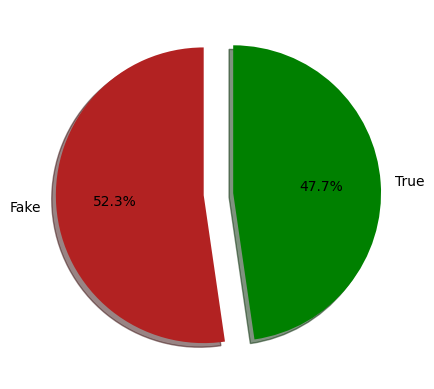

In [ ]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','green'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

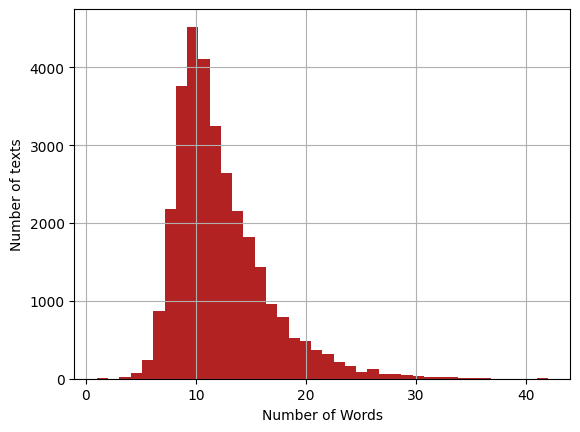

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.", "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding=True)                  # encode text
print(tokenized_sample_data)


{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist()).long()

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist()).long()

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist()).long()

In [ ]:
# Data Loader structure definition
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False                                   # false here means gradient need not be computed

### Define Model Architecture

In [ ]:

class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)                                             # dropout layer
      self.relu =  nn.ReLU()                                                     # relu activation function
      self.fc1 = nn.Linear(768,512)                                              # dense layer 1
      self.fc2 = nn.Linear(512,2)                                                # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)                                        # softmax activation function
    def forward(self, sent_id, mask):                                            # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                                                 # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                                                            # output layer
      x = self.softmax(x)                                                        # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 50

## Fake News Detection using BERT

We fine-tuned a pre-trained **BERT (bert-base-uncased)** model to classify news articles as *fake* or *real*.  
Instead of building from scratch, using BERT leverages **transfer learning**, since BERT already understands language structure from training on large text corpora.

### Model Architecture
- **BERT encoder**: Captures contextual word embeddings, i.e., it understands words based on their surrounding words.
- **Dense layer 1 (768 → 512)**: Reduces the 768-dimensional embedding (BERT’s output) into a more compact representation, while still preserving important features. This acts as a transformation layer before classification.
- **ReLU activation**: Introduces non-linearity so the model can learn complex patterns between words and labels.
- **Dropout (0.1)**: Applied after ReLU to randomly deactivate neurons during training. This prevents the model from memorizing the training data (overfitting) and improves generalization to unseen news articles.
- **Dense layer 2 (512 → 2)**: Maps features into 2 output classes (Fake vs Real).
- **LogSoftmax**: Converts raw scores into probabilities for each class, ensuring they sum to 1. This makes interpretation easier (e.g., 70% Fake, 30% Real).

### Training Setup
- **Optimizer: AdamW (lr = 1e-5)**  
  AdamW is chosen because it combines the advantages of:
  - **Adaptive learning rate**: It adjusts learning rates for each parameter, which helps BERT fine-tune efficiently.
  - **Weight decay (W)**: Helps reduce overfitting by penalizing large weights.  
  This makes it more stable than vanilla Adam or SGD, especially for transformer-based models.

- **Loss Function: Negative Log Likelihood (NLLLoss)**  
  We use NLLLoss instead of Binary Cross-Entropy because:
  - Our classifier outputs **two probabilities** (Fake, Real) from Softmax, not a single probability.
  - Binary Cross-Entropy expects a single sigmoid output.  
  - NLLLoss works directly with Softmax outputs, making it mathematically correct and numerically stable for multi-class classification (even though we have only 2 classes).

- **Epochs: 50**  
  We train for multiple passes over the dataset. Too few epochs = underfitting, too many = overfitting. We allow a maximum of 50 but monitor validation loss.

- **Early Stopping**  
  Training stops early if validation loss doesn’t improve for several epochs. This prevents wasting computation resources and avoids overfitting.

### Why this design works
- **Regularization (Dropout + AdamW weight decay)** prevents the model from memorizing specific news samples.
- **Two dense layers** add an extra transformation step, which improves learning compared to a single linear layer.
- **LogSoftmax + NLLLoss** ensures stable probability-based classification.
- **AdamW optimizer** is industry standard for fine-tuning transformers, ensuring faster convergence than SGD.

This architecture balances **accuracy, generalization, and interpretability**, making it suitable for a real-world fake news detection system.


### Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                                    # iterate over batches
    if step % 50 == 0 and not step == 0:                                            # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()                                                               # clear previously calculated gradients
    preds = model(sent_id, mask)                                                    # get model predictions for current batch
    loss = cross_entropy(preds, labels)                                             # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                                           # add on to the total loss
    loss.backward()                                                                 # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()                                                                # update parameters
    preds=preds.detach().cpu().numpy()                                              # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                                     # compute training loss of the epoch
                                                                                    # reshape predictions in form of (# samples, # classes)
  return avg_loss                                                                   # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                                                     # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):                                     # Iterate over batches
    if step % 50 == 0 and not step == 0:                                           # Progress update every 50 batches.
                                                                                   # Calculate elapsed time in minutes.
                                                                                   # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                                                  # Report progress
    batch = [t for t in batch]                                                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                                                         # Deactivate autograd
      preds = model(sent_id, mask)                                                # Model predictions
      loss = cross_entropy(preds,labels)                                          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)                                     # compute the validation loss of the epoch
  return avg_loss

## Training and Evaluation Functions

To train and validate the BERT-based classifier, we implemented two custom functions: `train()` and `evaluate()`. These functions handle the forward pass, loss computation, gradient updates, and evaluation.

### Training (`train()`)
1. **Model in training mode**:  
   `model.train()` ensures dropout layers are active, preventing overfitting during training.
2. **Mini-batch processing**:  
   Each batch from the `train_dataloader` contains:
   - `sent_id`: tokenized input IDs
   - `mask`: attention masks
   - `labels`: true labels (0 = real, 1 = fake)
3. **Gradient reset**:  
   `model.zero_grad()` clears previously accumulated gradients.
4. **Forward pass**:  
   The model predicts outputs (`preds`) for the batch.
5. **Loss computation**:  
   We use **Negative Log Likelihood Loss (NLLLoss)** since the model outputs log-probabilities from `LogSoftmax`.
6. **Backward pass**:  
   `loss.backward()` computes gradients with respect to model weights.
7. **Gradient clipping**:  
   `clip_grad_norm_()` prevents exploding gradients by capping their values.
8. **Optimizer step**:  
   `optimizer.step()` updates model parameters using **AdamW**, which is stable for transformers.
9. **Loss aggregation**:  
   The average loss across all batches is returned as the epoch training loss.

This ensures the model gradually adjusts its parameters to minimize classification errors.


### Evaluation (`evaluate()`)
1. **Model in evaluation mode**:  
   `model.eval()` disables dropout for consistent predictions.
2. **No gradient computation**:  
   `torch.no_grad()` reduces memory usage and speeds up validation.
3. **Forward pass only**:  
   Each batch is processed through the model, but no backward pass is performed.
4. **Loss tracking**:  
   Validation loss is computed and averaged across all batches.

### Why this design?
- **Separation of train/eval**: Ensures correct behavior of dropout and avoids unnecessary gradient calculations.
- **Gradient clipping**: Improves stability when training large models like BERT.
- **Loss averaging**: Provides a clear, interpretable metric for comparing epochs.
- **AdamW optimizer**: Industry-standard for fine-tuning transformers, combines adaptive learning with weight decay.

This setup provides a stable training process while preventing overfitting, and ensures evaluation metrics are unbiased by training operations.


### Model training

In [ ]:

best_valid_loss = float('inf')
train_losses = []      # to store training loss of each epoch
valid_losses = []      # to store validation loss of each epoch

# --- Early stopping parameters ---
patience = 5           # number of epochs to wait for improvement
min_delta = 0.0        # minimum change in val loss to qualify as improvement
epochs_no_improve = 0  # counter for early stopping
best_epoch = -1

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # training and validation
    train_loss = train()                                                        # train model
    valid_loss = evaluate()                                                     # evaluate model

    # save losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # --- Early stopping logic ---
    if valid_loss < (best_valid_loss - min_delta):
        best_valid_loss = valid_loss
        best_epoch = epoch + 1
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'new_model_weights.pt')  # save best model
        print(f" Improvement detected. Best val loss: {best_valid_loss:.6f} at epoch {best_epoch}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s). Patience = {patience}")

    if epochs_no_improve >= patience:
        print(f"\n Early stopping triggered at epoch {epoch+1}. Best was epoch {best_epoch} (val loss {best_valid_loss:.6f}).")
        break



 Epoch 1 / 50
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.556
Validation Loss: 0.488
 Improvement detected. Best val loss: 0.488208 at epoch 1

 Epoch 2 / 50
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of   

## Training Loop with Early Stopping

We implemented a custom training loop with **early stopping** to prevent overfitting and save computation time.  

### Key Components
1. **Tracking losses**  
   - `train_losses` and `valid_losses` store epoch-wise training and validation losses.  
   - `best_valid_loss` keeps the lowest validation loss seen so far.  

2. **Early stopping parameters**  
   - **Patience = 5**: If validation loss does not improve for 5 consecutive epochs, training stops.  
   - **min_delta = 0.0**: Validation loss must decrease by at least this margin to be considered an improvement.  
   - **epochs_no_improve**: Counts how many epochs have passed without improvement.  

3. **Per epoch operations**
   - Train for one epoch (`train()`).
   - Evaluate on validation set (`evaluate()`).
   - Append losses to tracking lists.
   - Print progress for monitoring.  

4. **Improvement check**
   - If the validation loss improves:  
     - Save model weights (`torch.save`) as the new best checkpoint.  
     - Reset `epochs_no_improve` counter.  
   - If no improvement:  
     - Increase `epochs_no_improve`.  

5. **Stopping criterion**
   - If `epochs_no_improve` reaches `patience`, stop training early.  
   - The model from the epoch with the **lowest validation loss** is preserved.  


### Why Early Stopping?
- Prevents **overfitting** by stopping when the model starts to memorize training data.  
- Saves **time and resources** since training is halted once the model stops improving.  
- Ensures we keep the **best performing model** rather than the last one.  

This approach balances training efficiency and generalization. It avoids unnecessary epochs while ensuring the saved model performs well on unseen data.


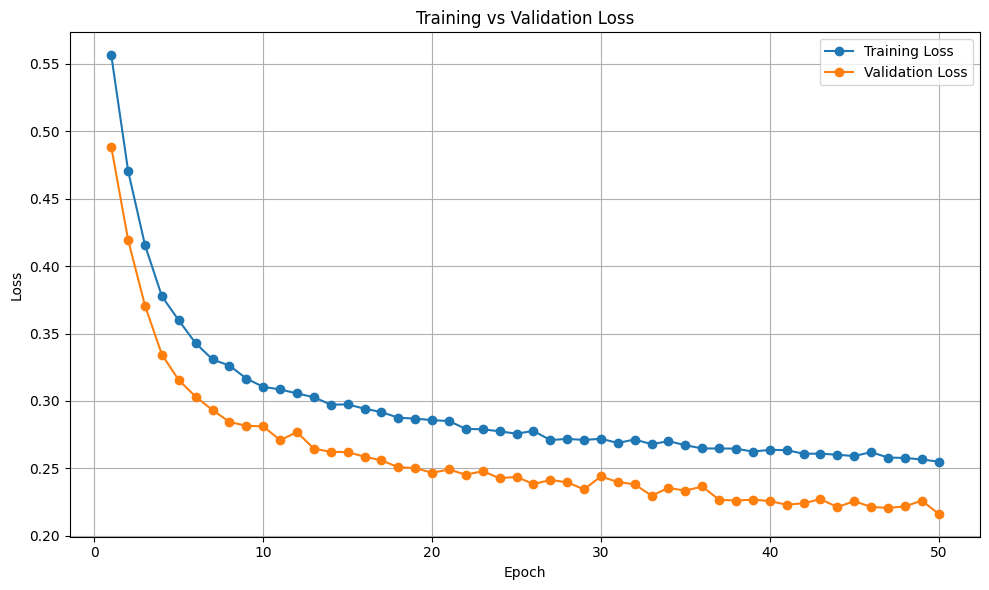

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Model performance

In [ ]:
# load weights of best model
path = 'new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3212
           1       0.92      0.91      0.91      3523

    accuracy                           0.91      6735
   macro avg       0.91      0.91      0.91      6735
weighted avg       0.91      0.91      0.91      6735



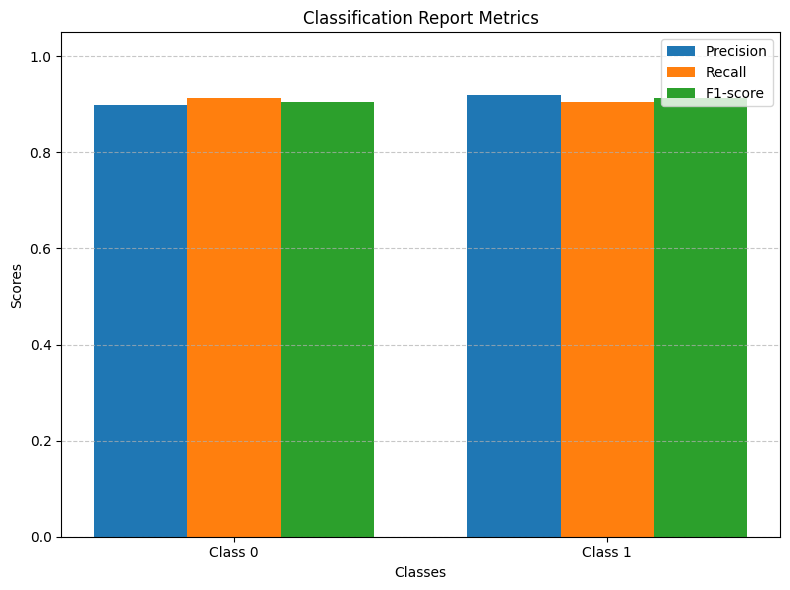

In [ ]:
# Get classification report as a dictionary instead of string
report_dict = classification_report(test_y, preds, output_dict=True)

# Extract class names (ignoring 'accuracy', 'macro avg', 'weighted avg')
classes = [cls for cls in report_dict.keys() if cls.isdigit()]

# Prepare data for plotting
precision = [report_dict[cls]['precision'] for cls in classes]
recall = [report_dict[cls]['recall'] for cls in classes]
f1_score = [report_dict[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))  # label locations
width = 0.25  # bar width

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-score')

# Labels and formatting
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(x)
ax.set_xticklabels([f"Class {cls}" for cls in classes])
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Fake News Predictions

In [ ]:
# load weights of best model
path = 'new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers",                          # True
                    "Trump wants Postal Service to charge 'much more' for Amazon shipments"   #True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds
print(preds)

[1 1 0 0 0]


In [ ]:
for text, pred in zip(unseen_news_text, preds):
    print(f"Text: {text}\nPrediction: {'Fake' if pred == 1 else 'True'}\n")

Text: Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Prediction: Fake

Text: WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy
Prediction: Fake

Text: U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources
Prediction: True

Text: Trump administration issues new rules on U.S. visa waivers
Prediction: True

Text: Trump wants Postal Service to charge 'much more' for Amazon shipments
Prediction: True



In [ ]:
# !pip install spacy wikipedia transformers --quiet

In [ ]:
# import spacy
# import wikipedia
# import torch
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

## Claim Extraction using spaCy

After detecting whether an article is **fake or real**, the next step in the pipeline is to extract **factual claims** from the text.  
For this, we use **spaCy**, a natural language processing library that provides tools for **tokenization**, **named entity recognition (NER)**, and **dependency parsing**.

### How it works
1. **Load spaCy Model**  
   - We load the `en_core_web_sm` model, which includes pre-trained word embeddings, part-of-speech tagging, and NER capabilities.  

2. **Sentence Processing (`extract_claims`)**  
   - Input text is divided into sentences using spaCy’s sentence segmentation.  
   - For each sentence:  
     - It must contain at least **one named entity** (e.g., PERSON, ORGANIZATION, LOCATION, NORP = nationality/religion/political group).  
     - It must also contain at least **one verb**, ensuring the sentence expresses an **action or relation**.  
   - If both conditions are met, the sentence is recorded as a **potential claim**.  

3. **Output**  
   - The function returns a list of sentences that are most likely to represent factual claims (Subject–Verb–Object structure).  

### Why this step?  
- **Fact verification systems** require well-formed claims to match against trusted knowledge bases.  
- Not every sentence is a claim; for example, purely descriptive or opinion-based sentences are filtered out.  
- This step ensures that only **fact-checkable statements** are passed to the next stage (Wikipedia evidence retrieval and NLI verification).


In [ ]:

# Load spaCy English core model
nlp = spacy.load("en_core_web_sm")

def extract_claims(text):
    """
    Extract Subject-Verb-Object claims from input text using spaCy dependency parsing and NER.
    Returns a list of claim sentences.
    """
    claims = []
    doc = nlp(text)
    for sent in doc.sents:
        # At least one named entity and a verb
        if any(ent.label_ in ("PERSON", "ORG", "GPE", "LOC", "NORP") for ent in sent.ents):
            if any(token.pos_ == "VERB" for token in sent):
                claims.append(sent.text)
    return claims


## Evidence Retrieval from Wikipedia

Once factual claims are extracted, the next step is to gather **reliable evidence** to check their validity.  
For this purpose, we use the **Wikipedia API**, as Wikipedia provides a large, human-curated knowledge base that is suitable for fact verification.

### Function: `retrieve_wikipedia_summary(claim)`
1. **Named Entity as Query**  
   - The function first processes the claim with **spaCy** to extract named entities (e.g., PERSON, ORG, GPE).  
   - The **first named entity** is chosen as the search query, since it usually represents the main subject of the claim.  

2. **Fallback to Key Noun**  
   - If no named entity is found, the function falls back to extracting **noun phrases** (e.g., "Postal Service").  
   - If no nouns exist, the function defaults to using the **first word** of the claim.  

3. **Wikipedia Search**  
   - Uses `wikipedia.page(query, auto_suggest=True)` to find the most relevant page.  
   - Extracts the **first summary paragraph**, which usually contains the most concise description of the subject.  

4. **Error Handling**  
   - If no page is found or retrieval fails, the function prints an error message and returns an empty string.  

### Why this step?  
- This step provides **external evidence** to support or refute claims.  
- By grounding claims in Wikipedia summaries, we can later use **Natural Language Inference (NLI)** models to test whether the claim is **entailed**, **contradicted**, or **unsupported**.  
- Reliable evidence retrieval is crucial to moving beyond classification and into **explainable fact verification**.


In [ ]:
def retrieve_wikipedia_summary(claim):
    """
    Retrieve the most relevant summary sentence(s) from Wikipedia for a given claim.
    """
    try:
        # Use the first named entity as the query
        claim_doc = nlp(claim)
        entities = [ent.text for ent in claim_doc.ents]
        if entities:
            query = entities[0]
        else:
            # fallback to key noun
            nouns = [chunk.text for chunk in claim_doc.noun_chunks]
            query = nouns[0] if nouns else claim.split()[0]
        # Search and get summary
        page = wikipedia.page(query, auto_suggest=True)
        summary = page.summary.split('\n')[0]  # Get first paragraph
        return summary
    except Exception as e:
        print(f"Wikipedia retrieval failed for '{claim}': {e}")
        return ""


## Claim Verification using RoBERTa-MNLI

The final step in the pipeline is to verify whether the extracted **claim** is supported by the retrieved **Wikipedia evidence**.  
We approach this as a **Natural Language Inference (NLI)** problem using a pre-trained **RoBERTa-large-MNLI** model.

### Function: `verify_claim_with_nli(claim, evidence)`
1. **Model & Tokenizer**  
   - We load the **RoBERTa-large-MNLI** model, which has been trained on the Multi-Genre Natural Language Inference (MNLI) dataset.  
   - This model can classify pairs of sentences into one of three categories:
     - **Entailment**: Evidence supports the claim.  
     - **Contradiction**: Evidence refutes/contradicts the claim.  
     - **Neutral**: Evidence is related but does not confirm or deny the claim.  

2. **Input Pair Construction**  
   - The function takes a **claim** (from the news article) and its corresponding **evidence** (from Wikipedia).  
   - Both are tokenized together into a single input for the NLI model.  
   - Inputs are truncated to a maximum length of 256 tokens to fit model constraints.  

3. **Prediction**  
   - The model outputs raw logits for the three classes.  
   - The class with the highest score is selected using `torch.argmax`.  
   - The predicted class is mapped to a human-readable label (`contradiction`, `neutral`, `entailment`).  

4. **No Evidence Case**  
   - If no evidence is available from Wikipedia, the function returns `"No evidence"`.

### Why this step?  
- Simple classification of articles as *fake* or *real* is not enough.  
- This stage adds **explainability**, showing **why** a claim is considered true or false.  
- By pairing claims with external evidence and running them through an **NLI model**, we move towards a more **trustworthy and interpretable fact verification system**.


In [ ]:
# Load RoBERTa-MNLI model for entailment
nli_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
nli_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")

def verify_claim_with_nli(claim, evidence):
    """
    Use RoBERTa-MNLI to classify claim-evidence pairs as entailment/contradiction/neutral.
    """
    if not evidence:
        return "No evidence"
    inputs = nli_tokenizer(claim, evidence, return_tensors='pt', truncation=True, max_length=256)
    with torch.no_grad():
        logits = nli_model(**inputs).logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    label_map = {0: "contradiction", 1: "neutral", 2: "entailment"}
    return label_map[predicted_class_id]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
results = []

# Choose the set you want to process
ARTICLES = unseen_news_text[:10]  # change to val_text[:10] or data['text'][:10] if you like

for i, article in enumerate(ARTICLES, start=1):
    claims = extract_claims(article)
    if not claims:
        # still record the article in case there are no claims
        results.append({
            "Article #": i,
            "Article Text": article,
            "Claim": "",
            "Evidence": "",
            "Verification": "No claim extracted"
        })
        continue

    for claim in claims:
        evidence = retrieve_wikipedia_summary(claim)
        verdict = verify_claim_with_nli(claim, evidence)
        results.append({
            "Article #": i,
            "Article Text": article,
            "Claim": claim,
            "Evidence": evidence if evidence else "",
            "Verification": verdict
        })

# Convert to DataFrame for inspection / export
df_pipeline = pd.DataFrame(results)

# Nice, grouped printout
for i in sorted(df_pipeline["Article #"].unique()):
    block = df_pipeline[df_pipeline["Article #"] == i]
    print(f"\n=== Article {i} ===")
    print(block["Article Text"].iloc[0])
    for _, row in block.iterrows():
        if row["Claim"]:
            print("\nClaim:", row["Claim"])
            print("Evidence:", row["Evidence"] if row["Evidence"] else "[No evidence found]")
            print("Verification:", row["Verification"])
    print("=" * 80)


Wikipedia retrieval failed for 'Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing': Page id "donald trump seeds out" does not match any pages. Try another id!

=== Article 1 ===
Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing

Claim: Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Evidence: [No evidence found]
Verification: No evidence

=== Article 2 ===
WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy

Claim: George W. Bush Calls Out Trump For Supporting White Supremacy
Evidence: George Walker Bush (born July 6, 1946) is an American politician and businessman who was the 43rd president of the United States from 2001 to 2009. A member of the Republican Party and the eldest son of the 41st president, George H. W. Bush, he served as the 46th governor of Texas from 1995 to 2000.
Verification: contradiction

=== Article 3 ===
U.S. lawmakers question businessman at 2016 Trump Tower